In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))
getwd()

[1] "/mnt/hdd/develop/kaggle/house-prices/R/R"

In [3]:
source('main.R')

data <- kaggle.house$loadData()
df.training <- data$train
df.testing <- data$test
df.combined <- kaggle.house$getCombinedDataset(df.training, df.testing)

c(nrow(df.training),   nrow(df.testing),   nrow(df.combined))
setdiff(df.training %>% colnames, df.testing %>% colnames)

[1] 1460 1459 2919

[1] "SalePrice"

In [4]:
c('Alley', 
  'BsmtCond', 
  'BsmtExposure', 
  'BsmtFinType1', 
  'BsmtFinType2', 
  'BsmtQual',
  'Fence',
  'FireplaceQu',
  'GarageCond',
  'GarageFinish',
  'GarageQual',
  'GarageType',
  'MasVnrType',
  'MiscFeature',
  'PoolQC',
  'SalePrice',
  'dataSource') -> colums.with.good.na

# Attributes where NAs need be fixed
df.combined %>% 
select(-dplyr::one_of(colums.with.good.na)) %>% 
purrr::keep(function (col) { sum(is.na(col)) > 0 }) -> df.combined.na.for.fix

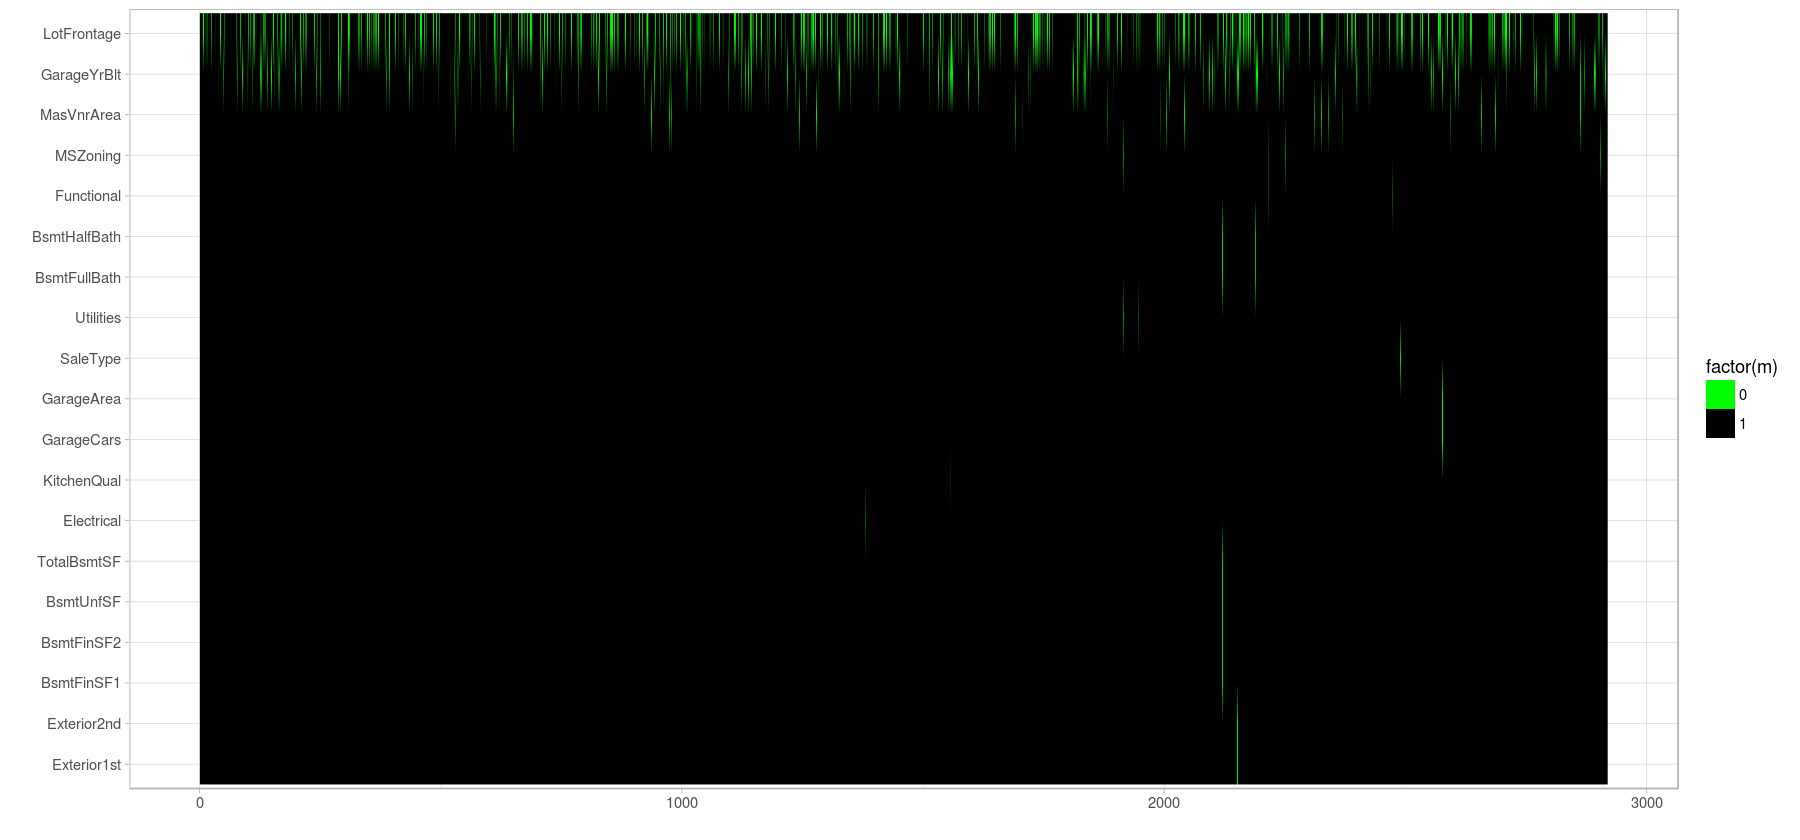

In [26]:
options(repr.plot.width = 15, repr.plot.height = 7)

cols.order <- df.combined.na.for.fix %>% is.na %>% colSums %>% sort %>% names

df.combined.na.for.fix %>%
mutate(x = row_number()) %>%
gather(col.name, col.value, -x) %>% 
mutate(m = ifelse(is.na(col.value), 0, 1)) %>% 
select(-col.value) %>%
mutate(col.name = factor(col.name, levels=cols.order)) %>%
ggplot() + geom_raster(aes(x=x, y=col.name, fill=factor(m)), interpolate=TRUE) + 
scale_fill_manual(values=c("green", "black")) + theme_light() + ylab("") + xlab("") 

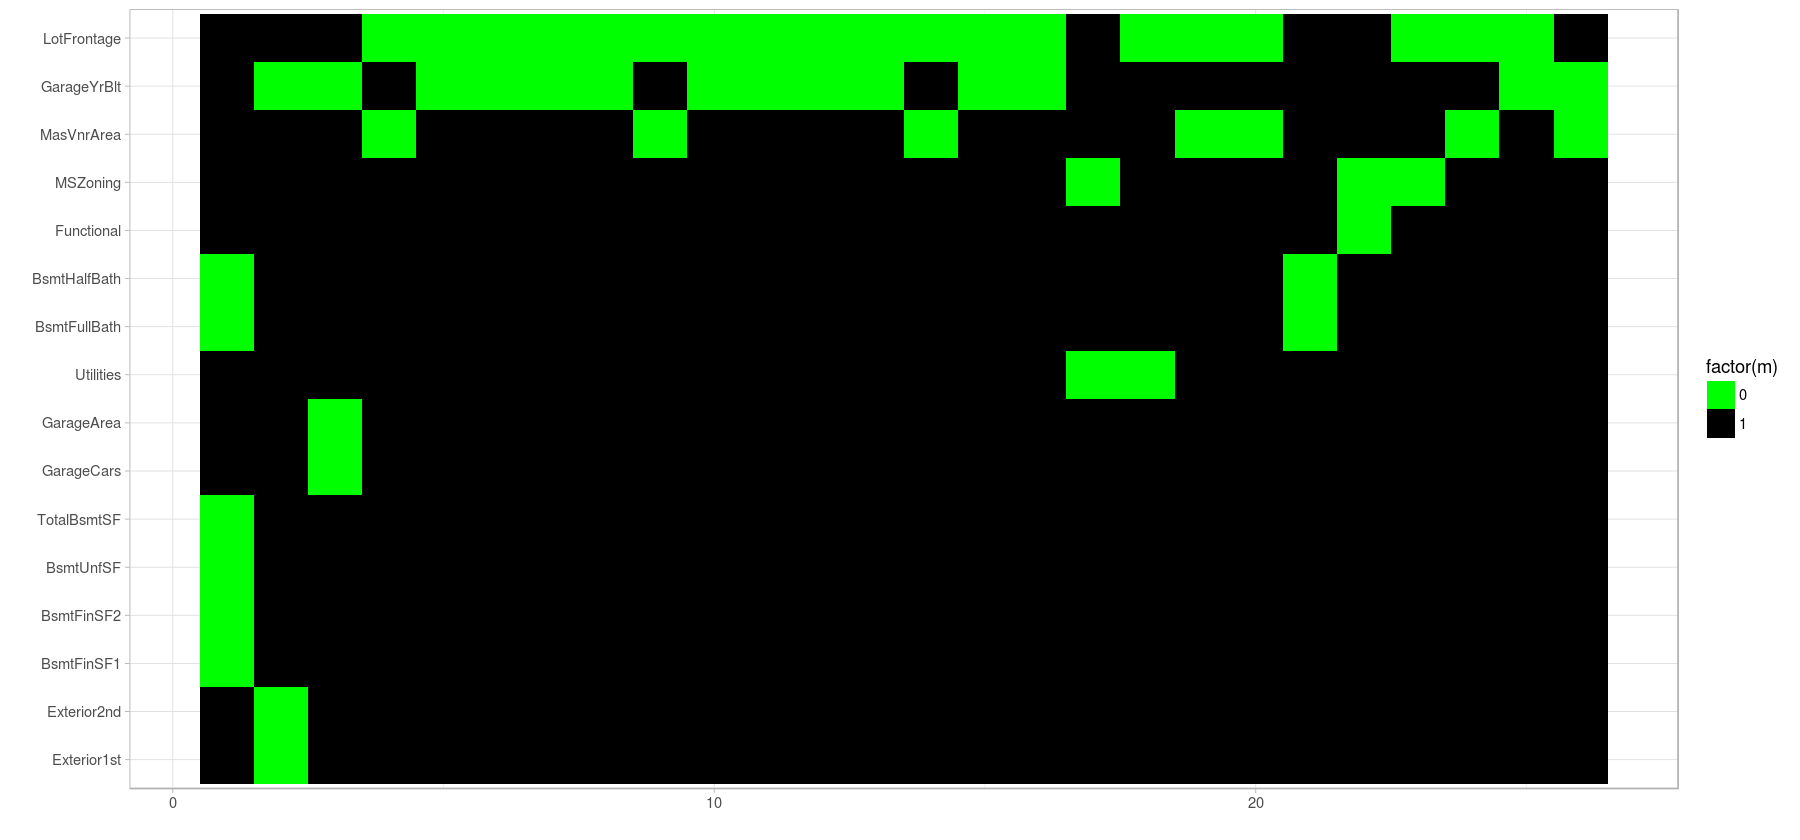

In [55]:
df.combined.na.for.fix %>% 
mutate(na.row.count = apply(., 1, function(r) { sum(is.na(r)) })) %>% 
filter(na.row.count > 1) %>%
arrange(desc(na.row.count)) %>%
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>%
mutate(x = row_number()) %>%
gather(col.name, col.value, -x) %>% 
mutate(m = ifelse(is.na(col.value), 0, 1)) %>% 
select(-col.value) %>%
mutate(col.name = factor(col.name, levels=cols.order)) %>%
ggplot() + geom_tile(aes(x=x, y=col.name, fill=factor(m))) + 
scale_fill_manual(values=c("green", "black")) + theme_light() + ylab("") + xlab("") 

In [5]:
df.combined %>% select_if(is.character) %>% 
select(-dplyr::one_of(colums.with.good.na)) %>%
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>%
purrr::map(function (col) { table(col, useNA='always') %>% as.data.frame }) -> tmp

tmp[tmp %>% names %>% sort]

col,Freq
FuseA,188
FuseF,50
FuseP,8
Mix,1
SBrkr,2671
NA,1
col,Freq
AsbShng,44
AsphShn,2
BrkComm,6


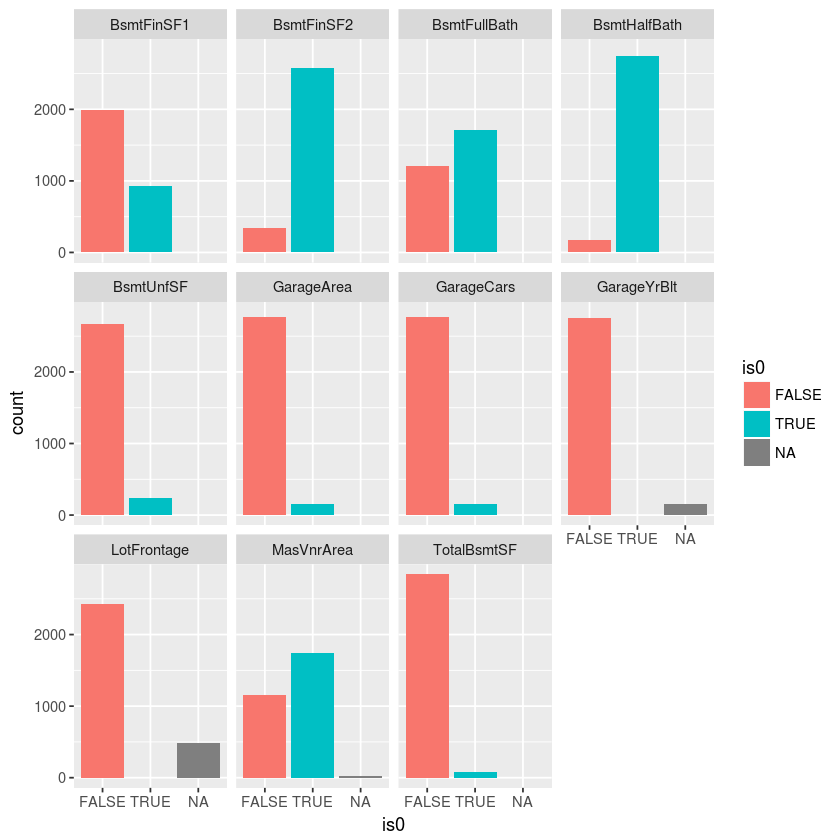

In [162]:
df.combined %>% select(-SalePrice) %>% select_if(is.numeric) %>%
purrr::keep(function (col) { sum(is.na(col)) > 0 }) %>%
select(order(colnames(.))) -> df.combined.numeric.na

df.combined.numeric.na %>% 
gather(attr.name, attr.val) %>%
mutate(is0 = ifelse(attr.val == 0, T, F)) %>%
ggplot() + 
geom_bar(aes(is0, fill=is0)) + 
facet_wrap(~attr.name)

In [50]:
kaggle.house$na$test_na_fixers(df.combined)

df.combined.fixed <- kaggle.house$na$fixAll(df.combined)
df.training.fixed <- df.combined %>% filter(dataSource == "train")
df.testing.fixed <- df.combined %>% filter(dataSource == "test")

[1] "run tests ..."


In [134]:
?gather